In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm 

import matplotlib.pyplot as plt #visuals
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)


PyTorch version 2.4.0
Numpy version 1.26.4
Pandas version 2.2.3


In [2]:
class PlayingCardDataset(Dataset): 
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
dataset = PlayingCardDataset(
    data_dir='/kaggle/input/cards-image-datasetclassification/train'
)

In [4]:
len(dataset)

7624

34


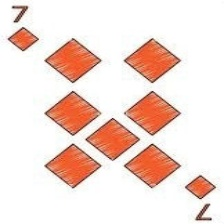

In [5]:
image, label = dataset[5000]
print(label)
image

In [6]:
# Get a directory associating target values within the folder
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
target_2_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_2_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [8]:
image, label = dataset[200]
image.shape

torch.Size([3, 128, 128])

In [9]:
# iterate over dataset
for image, label in dataset:
    break

# Dataloaders 
* Batching our dataset

In [10]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
for images, labels in dataloader:
    break

In [12]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

# The Pytorch Model 
Using a Pytorch dataset can be structed way to organize your data, pytorch models follow similar paradigm.
* Starting by creating the model from scratch defining each layer
* You can use a new package called timm for tasks like image classification which I highly recommend.
* With this model I hope you get a better understanding og pytorch and shaping data with each layer. Which is around 53 targets.

In [13]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)
    
    def forward(self, x):
        # Connect the parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output
    

In [14]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [15]:
example_out = model(images)
example_out.shape #[Checking our batch_size, num_classes]

torch.Size([32, 53])

# The Training Loop For The Model
* This will be where we would feed the model to train 
* We want to make sure that we vaildate our model on the data, since it has not been trained on it yet. So we going to make it easy. We can create two datasets using our exisiting class.
* This loop we become easier to understand when training future models, which you can load in data to the model in batches.

* Then we going perform a calculation with loss and peform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
* Important Two!!
* optimizer, adam is the best place to start for most tasks.
* loss function is what the model will optimize for in this model.

In [16]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [17]:
criterion(example_out, labels)

tensor(3.9502, grad_fn=<NllLossBackward0>)

# SettingUp Datasets

In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

training_folder = '/kaggle/input/cards-image-datasetclassification/train/'
validing_folder = '/kaggle/input/cards-image-datasetclassification/valid/'
testing_folder ='/kaggle/input/cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(training_folder, transform=transform)
valid_dataset = PlayingCardDataset(validing_folder, transform=transform)
test_dataset = PlayingCardDataset(testing_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
device = torch.device("cuda:0" if torch. cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


Epoch 1/5 - Train loss: 1.590006428150165, Validation loss: 0.5022220984944757


100%|██████████| 9/9 [00:00<00:00, 14.39it/s]


Epoch 2/5 - Train loss: 0.561743903260166, Validation loss: 0.21017258594620902


100%|██████████| 9/9 [00:00<00:00, 13.60it/s]


Epoch 3/5 - Train loss: 0.33420909698837575, Validation loss: 0.2233366498407328


100%|██████████| 9/9 [00:00<00:00, 12.53it/s]


Epoch 4/5 - Train loss: 0.2342090853973676, Validation loss: 0.2921500489396869


100%|██████████| 9/9 [00:00<00:00, 13.78it/s]

Epoch 5/5 - Train loss: 0.17979386813571172, Validation loss: 0.13093733899998214


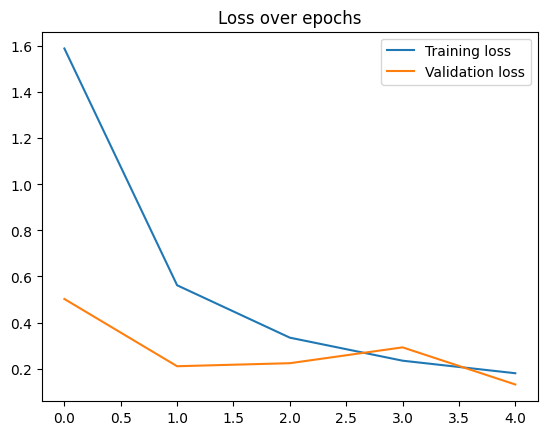

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Evaluating The Results 
* Just wanting to see the process of everything working on the model

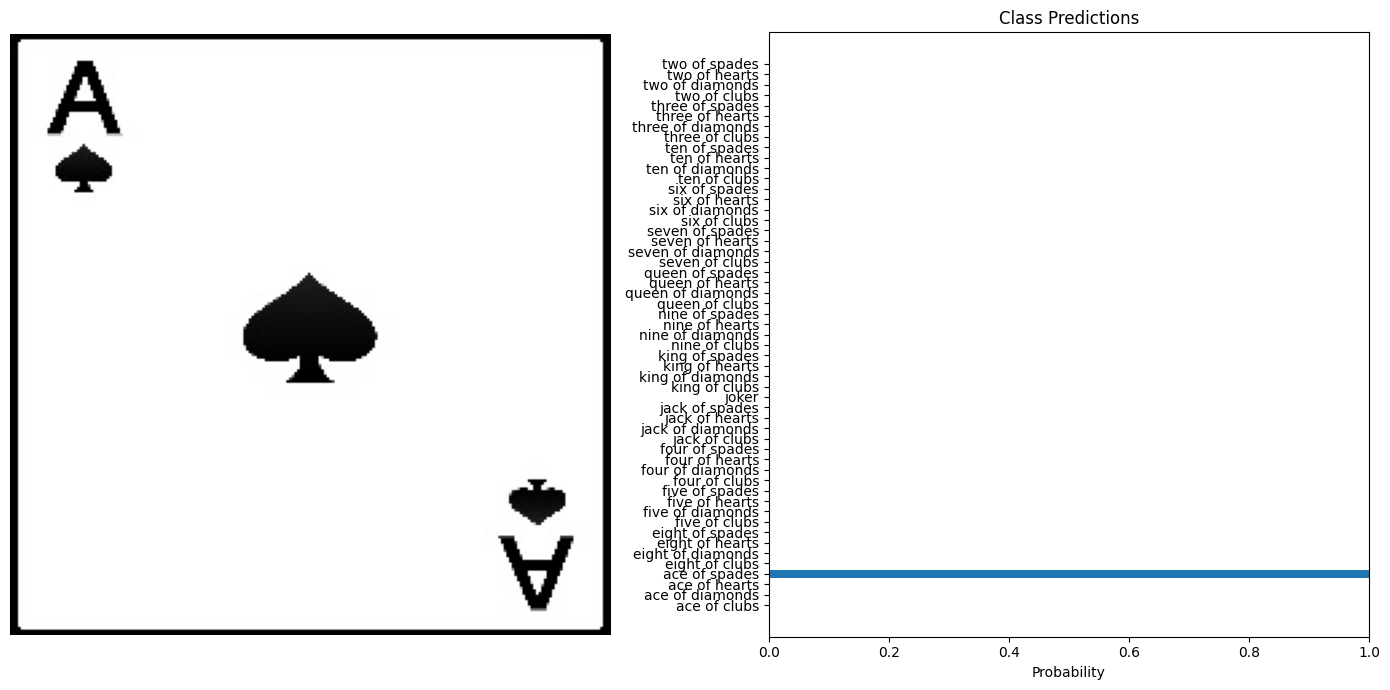

In [22]:
import torch 
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        return probabilities.cpu().numpy().flatten()
    
# Visualization
def visualize_predictions(orig_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    # Display image
    axarr[0].imshow(orig_image)
    axarr[0].axis("off")
        
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)
        
    plt.tight_layout()
    plt.show()
        
# Example usage
test_image = '/kaggle/input/cards-image-datasetclassification/test/ace of spades/1.jpg'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
    
orig_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(orig_image, probabilities, class_names)


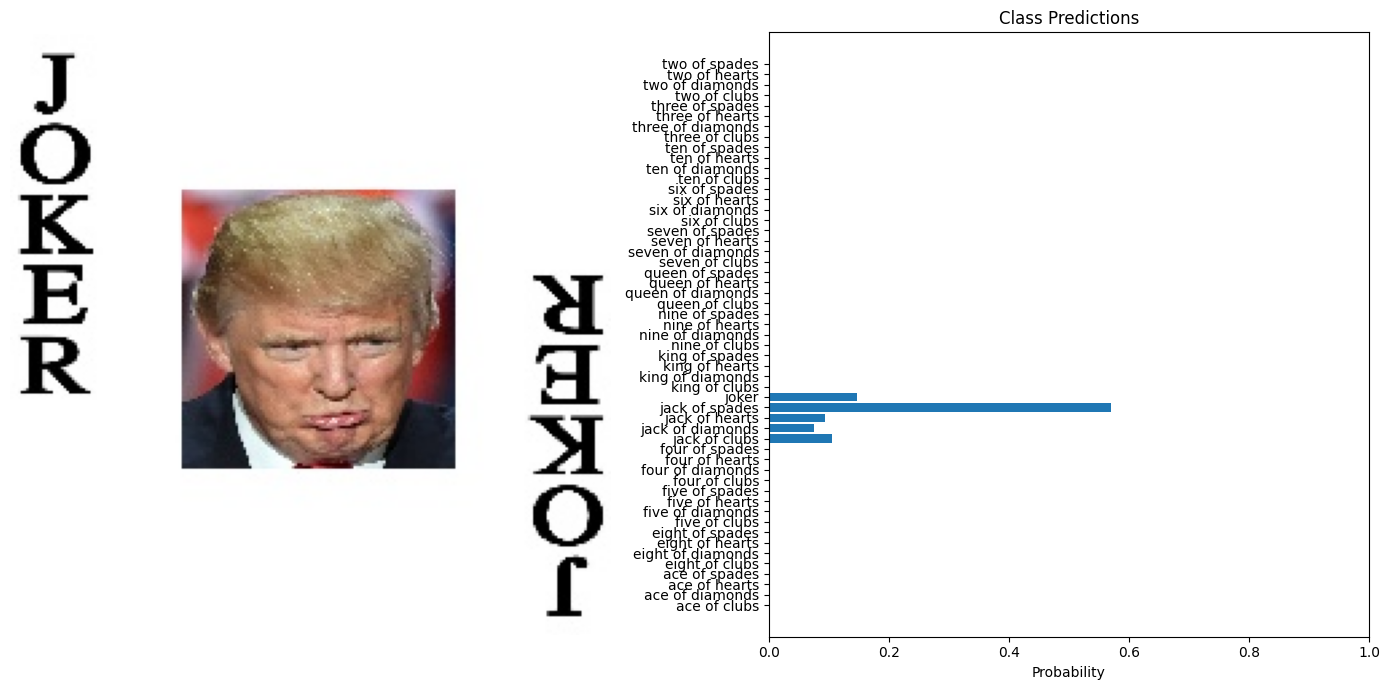

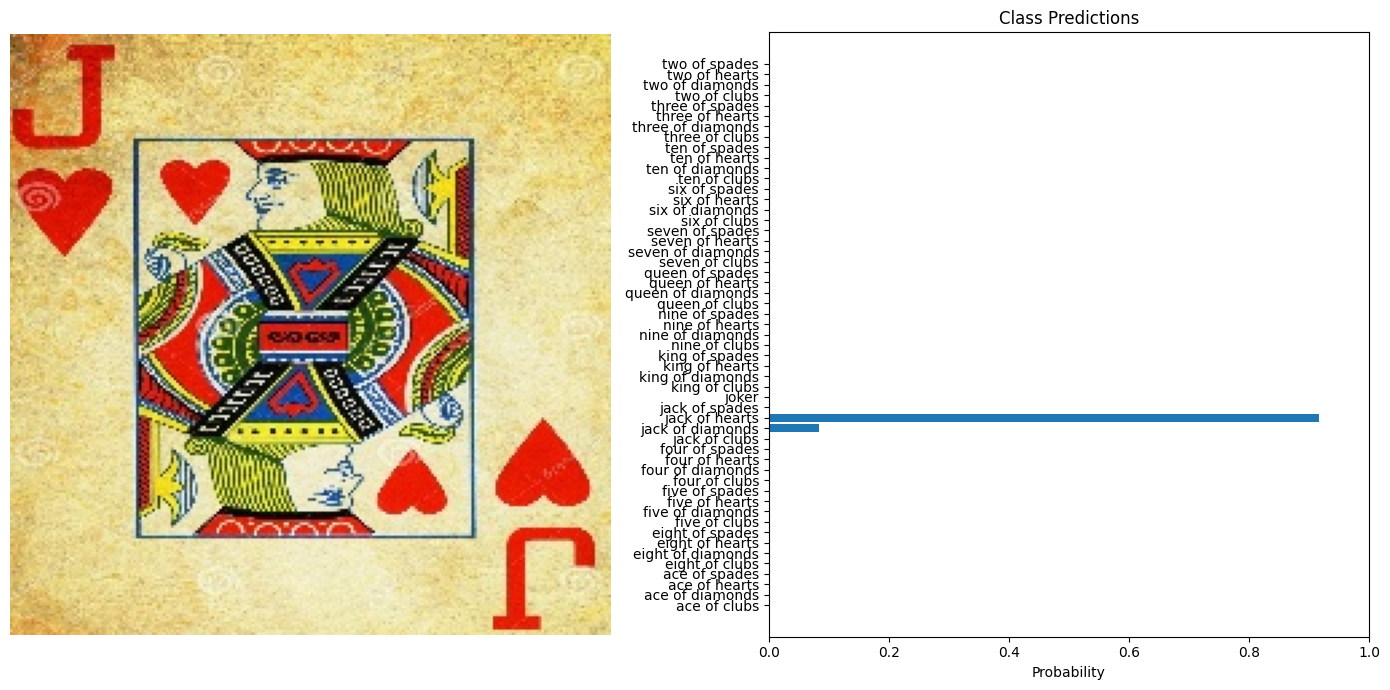

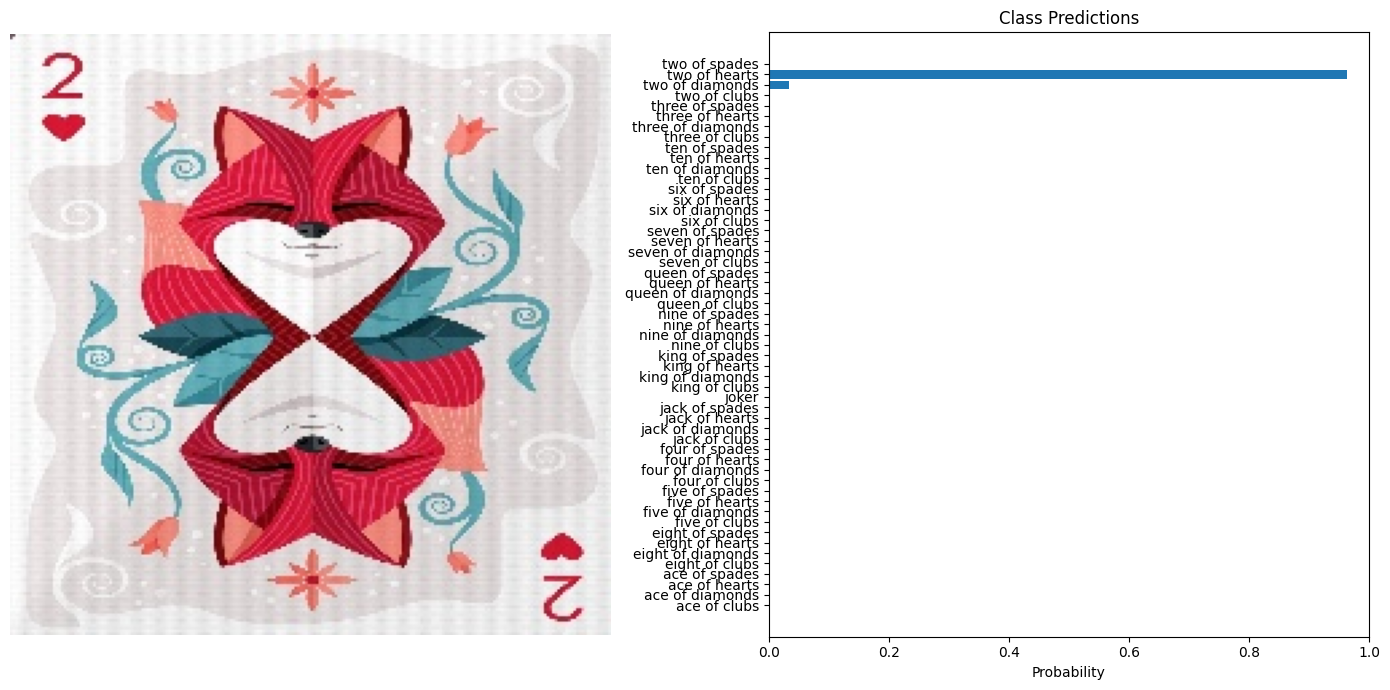

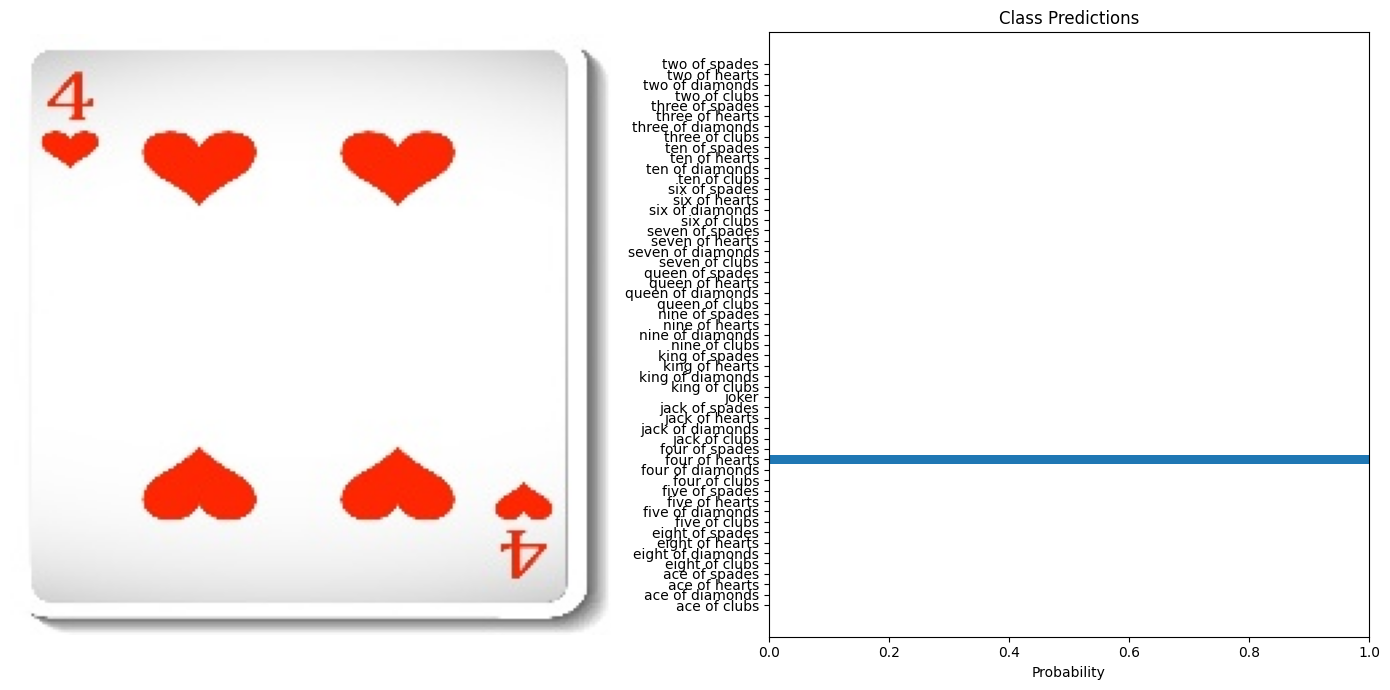

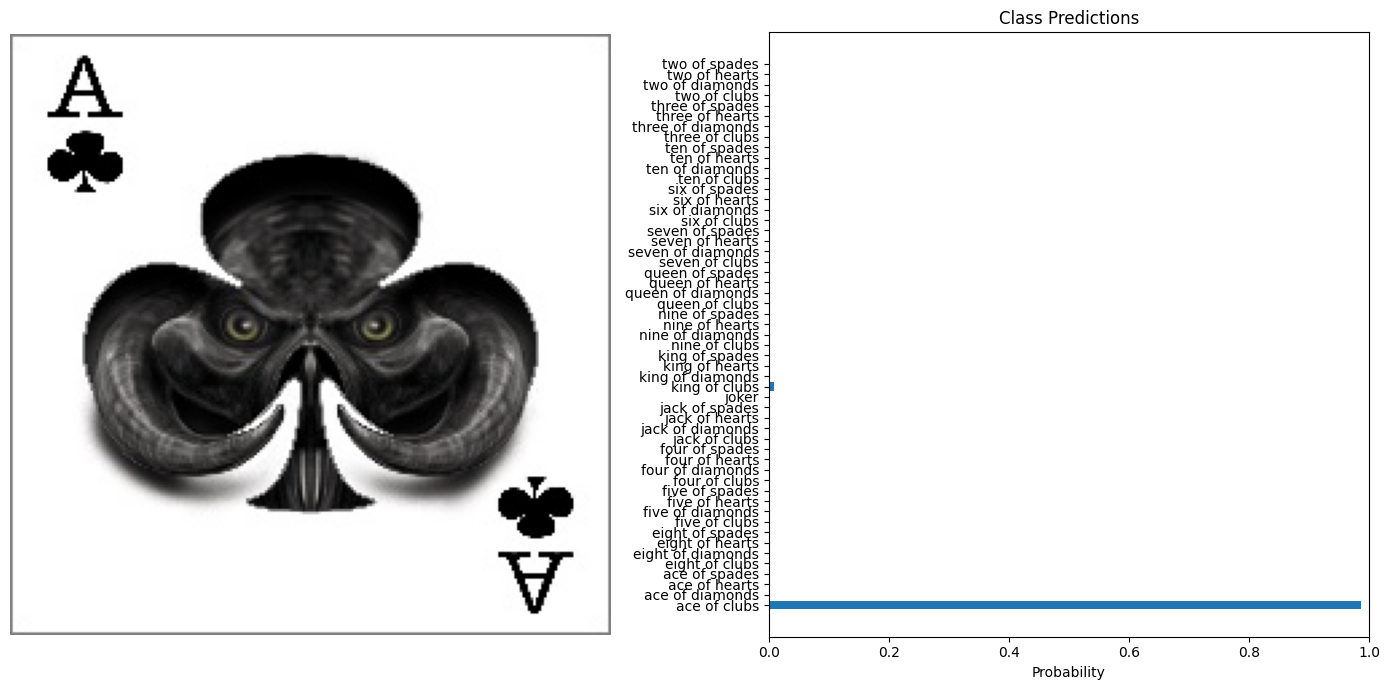

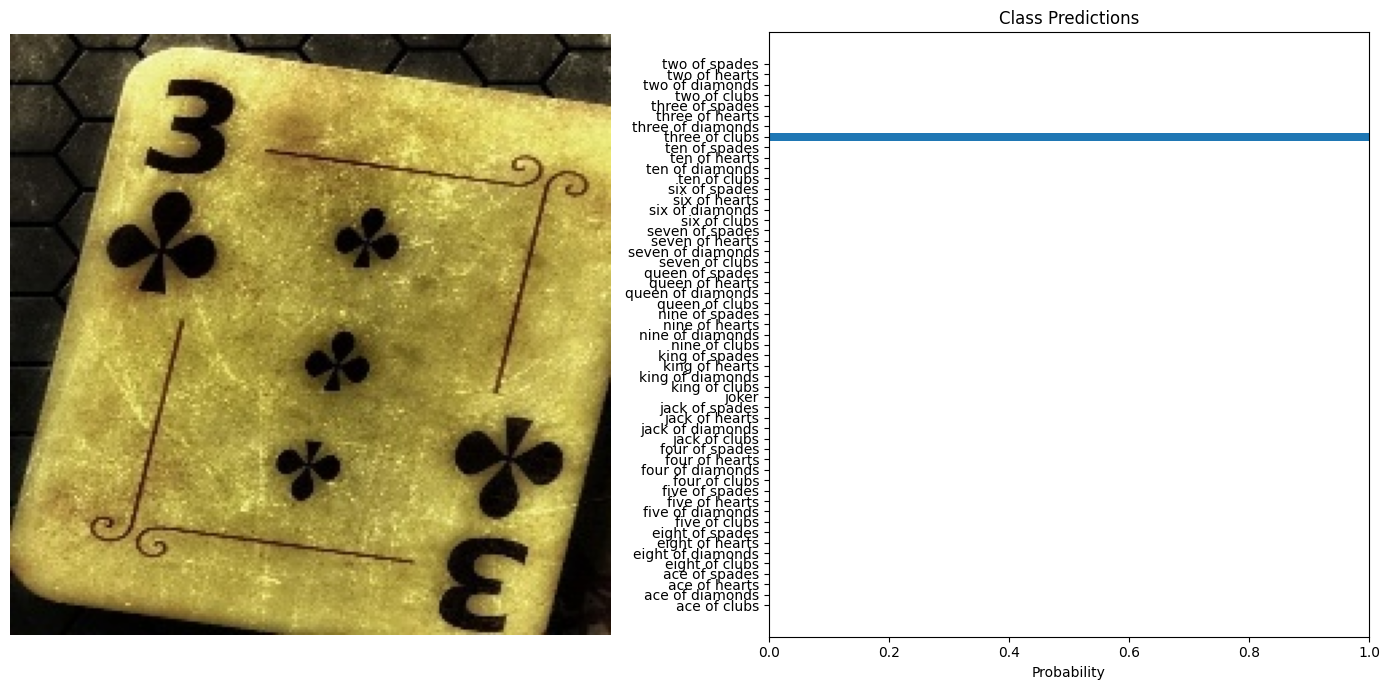

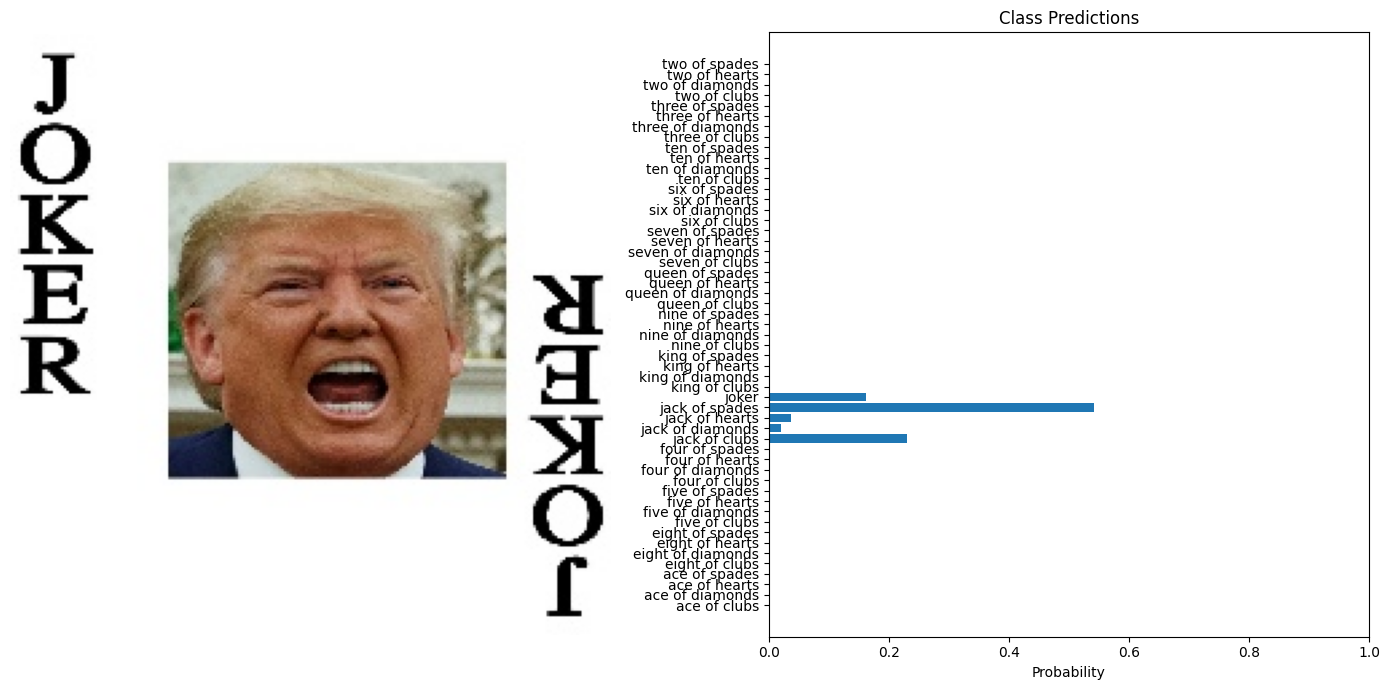

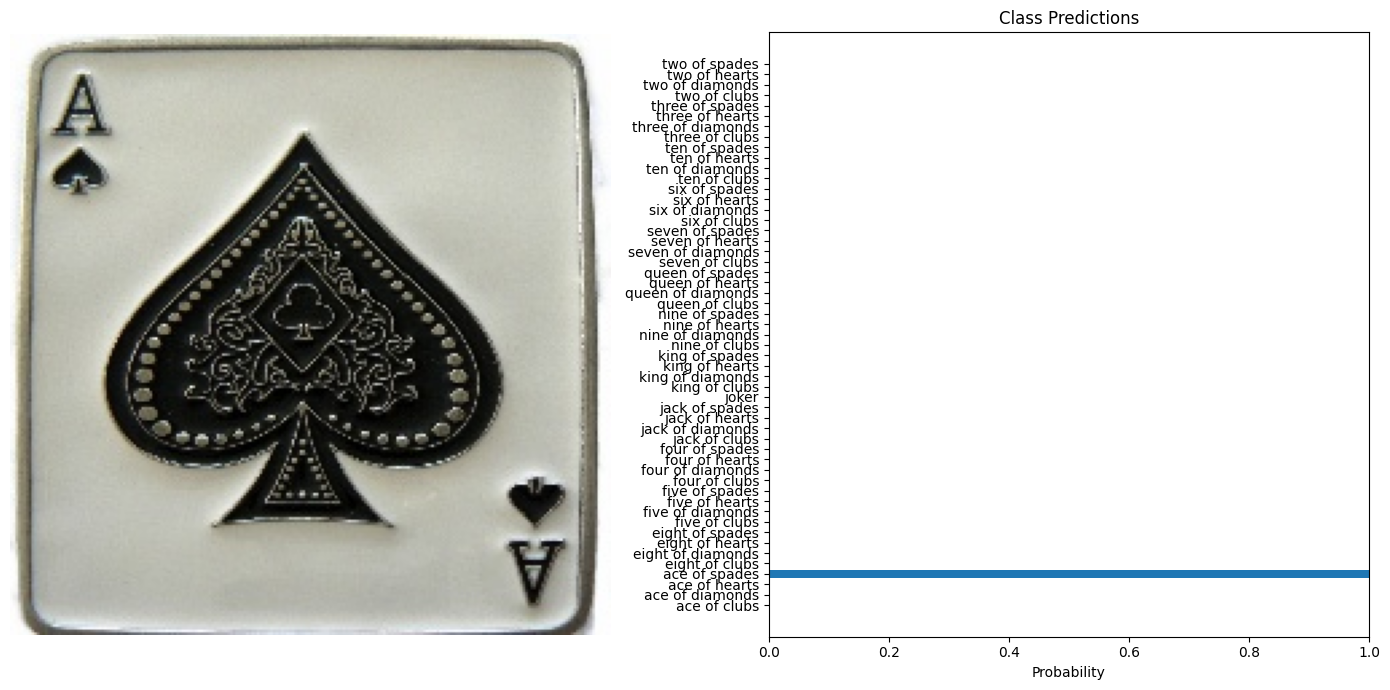

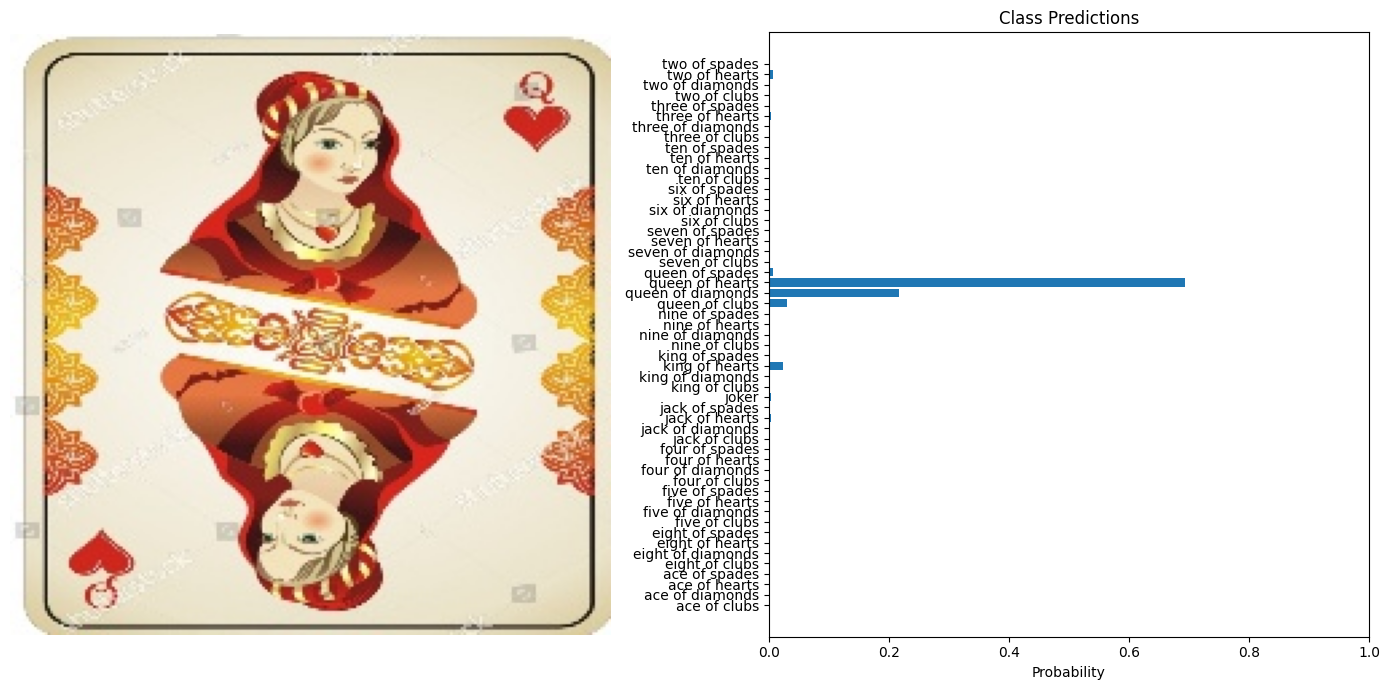

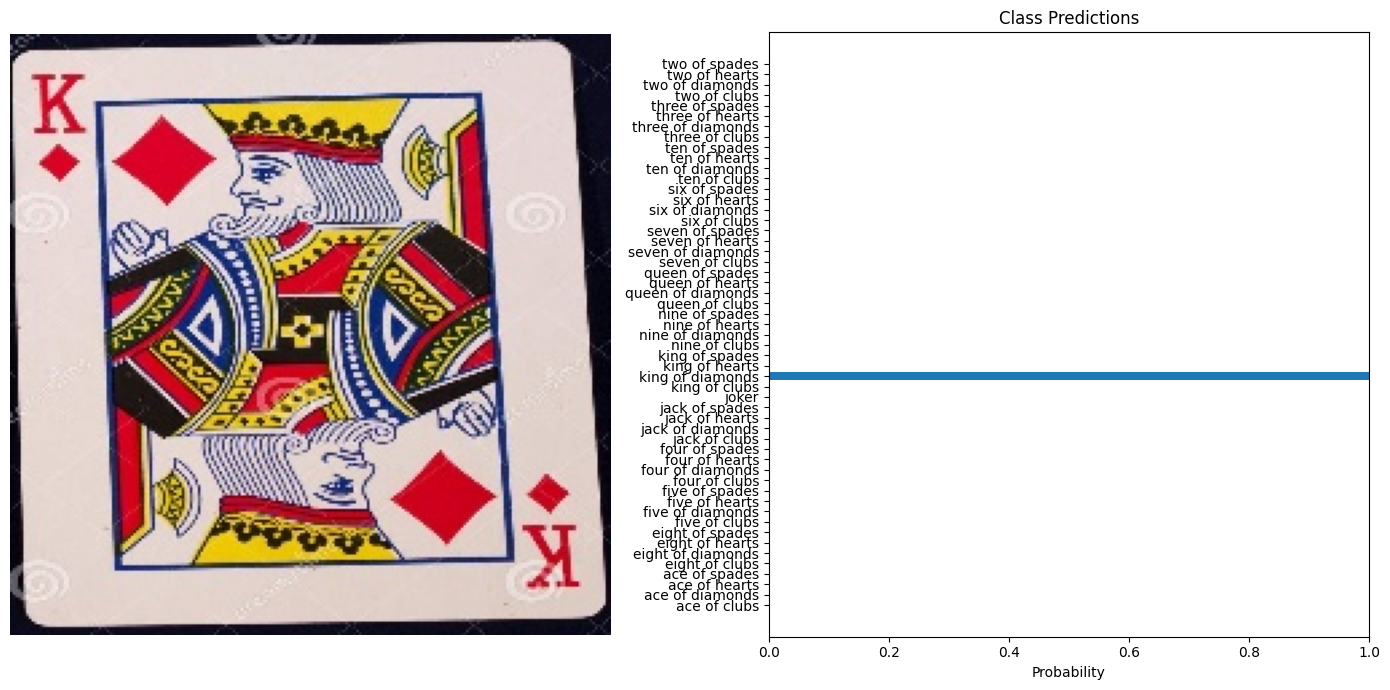

In [23]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)
for example in test_examples:
    orig_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)
    
    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(orig_image, probabilities, class_names)